In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

$\newcommand{\UCPS}{\mathrm{UCP^\textrm{STOCH}}}$
$\newcommand{\UCPD}{\mathrm{UCP^\textrm{DET}}}$

# Stochastic Unit Commitment Problem

## Scenario-based Problem formulation
Consider a UCP problem where the demand series is uncertain $\textbf{D}$ according to some multivariate distribution $\mathcal{D}$. 

Think of the sample space of $\mathcal{D}$ as a set of demand series $\{D_{t\xi}\}_{\Xi}$, i.e. "scenarios", where $\xi \in \Xi$ is the scenario index, characterized by a probability $\pi_\xi$.

For example, we could consider three possible scenarios: average demand, high-demand and low-demand.

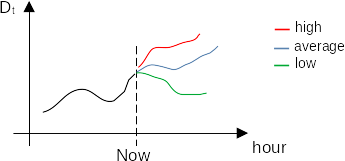

How should we schedule power plants given that we cannot know in advance which of the three (or more) scenarios will play out in the future?<br>
We split decisions in two types: 
* first-stage: decisions taken now, i.e. before the actual unknown scenario plays out
* recourse: the decisions taken in the future to react to the actual scenario that happened.  

For the UCP we can think of a "schedule-first" model which decides up-front the schedule of the power plants over the horizon, and leaves the actual production levels of the power plants as a recourse variable.

The problem will then have a single array of commitment variables, as they are the same across scenarios, and a separate array of production variables for each scenario.

We then assume to minimize the **expected** cost of the solution, i.e. the mean of production costs across scenarios, weighted by the respective probabilities.
Other possible choices could be to minimize the worst-case cost ("robust optimization") or other moments/functions of the distribution of production costs.  

The modelling yields the stochastic program $\UCPS_\Xi$:
$\newcommand{\var}[1]{{\color{blue}{#1}}}$
$$\min \mathbf{c}^\top \var{\mathbf{s}} + \sum_{\xi \in \Xi} \pi_\xi \left (\mathbf{l}^\top \var{\mathbf{p}_\xi} + c_{ENP} \var{\textbf{ENP}_\xi} +  c_{EIE} \var{\mathbf{EIE}_\xi} \right), \quad [\var{\mathbf{s}}, \var{\mathbf{p}_\xi}, \var{\textbf{ENP}_\xi}, \var{\textbf{EIE}_\xi}] = \var{\mathbf{x}_\xi} \in \mathcal{X}_{\Xi} ~~\forall \xi \in \Xi $$

where $\mathcal{X}_{\xi}$ represent the constraints that need to be satisfied in each scenario. In this example, they're the same ones in the original UCP model (demand satisfaction and production limits), but with the respective scenario demand. 

### Choosing scenarios
The more scenarios are considered, the more robust and "accurate" the solution becomes. On the other hand, too many scenarios can make the model too big, therefore expensive to solve, while providing little additional benefits in terms of solution quality (i.e. robustness and accuracy).

In practice, "scenario clustering" methods are used to reduce the dimensionality of the problem, where if two scenarios are very similar, they're replaced with their average scenario, and so recursively; see e.g. [here](https://www.researchgate.net/publication/230873408_Lectures_on_stochastic_programming_Modeling_and_theory) page 71.  

In [3]:
from wurlitzer import sys_pipes
from plotnine import *
from mizani.formatters import percent_format
import itertools
import pandas as pd
import numpy as np
import random
from pulp import PULP_CBC_CMD

from UCP.data import UCPData
import UCP.output as ucp_out
import UCP.stochastic.model as stoch_modeller
import UCP.model as modeller
from UCP.stochastic.scen_gen import make_scenarios
import UCP.stochastic.charts as charts
from UCP.stochastic.solution_evalution import evaluate_solution
from generic.optimization.solution_extraction import extract_solution

random.seed(123456)

In [4]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [5]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

# Data

**In `data`**

Thermal plants: table describing thermal plants

* `plant`: plant id
* `l_cost`: cost function slope
* `c_cost`: cost function constant term
* `min_power`, `max_power`: minimum and maximum production value when plant is on
* `min_on`, `min_off`: minimum on and off time (in hours)


Expected loads: hourly demand. Relevant fields:
* `period`: hour
* `value`: load

**In `scenarios`**

Scenarios: list of:
* loads : series with load values for a given scenario
* probability: scenario probability, number between 0 and 1

Here we generate 40 scenarios.

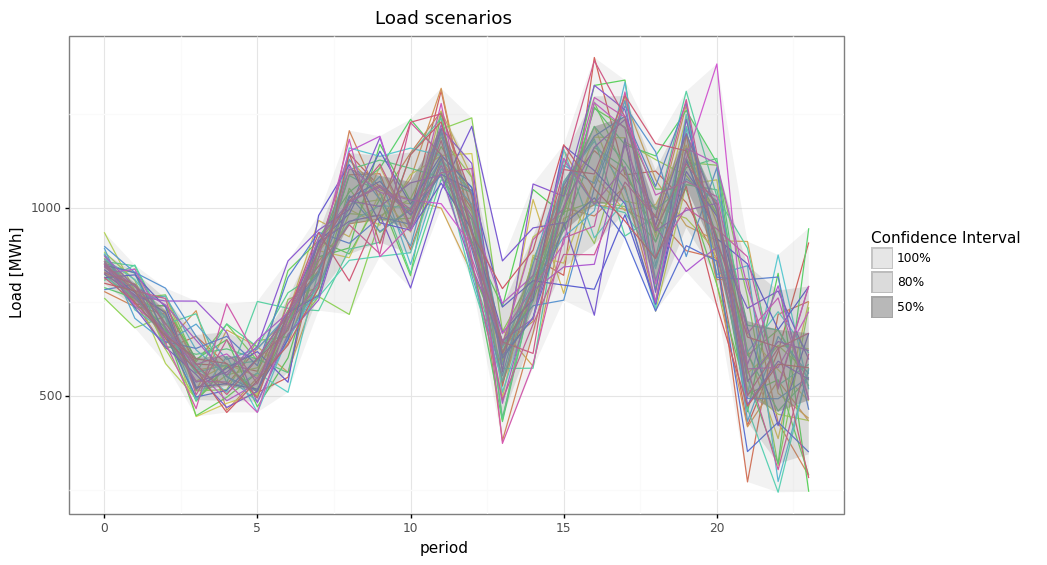

<ggplot: (8759885661425)>

In [6]:
scenarios = make_scenarios(data, noise_ratio=0.15, n=40)
charts.load(scenarios)

# Solution

In [7]:
stoch_ucp = stoch_modeller.create_model(data, scenarios)

In [8]:
stoch_ucp.model.solve()
print(f"Cost: {stoch_ucp.model.objective.value()}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ataverna/pyvenv/lagrangian_example/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/3fa080c05e294faca139bee241cad551-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/3fa080c05e294faca139bee241cad551-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21565 COLUMNS
At line 88496 RHS
At line 110057 BOUNDS
At line 110778 ENDATA
Problem MODEL has 21560 rows, 12240 columns and 53730 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 145838 - 0.41 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 264 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 147 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 40 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 38 strengthened rows, 0 substitutions


# Output

In [9]:
solution = extract_solution(stoch_ucp)

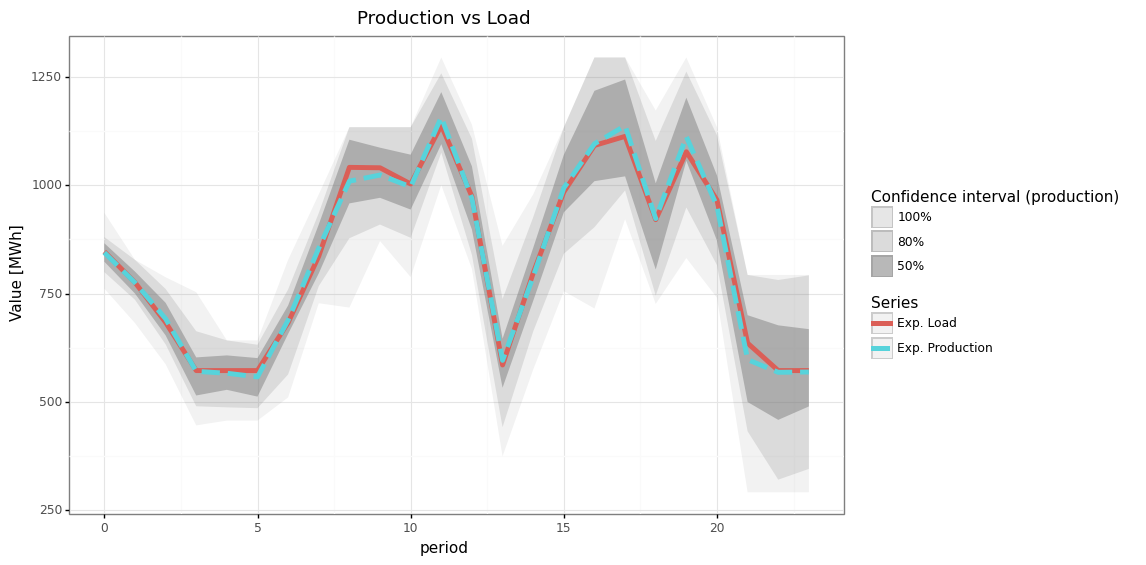

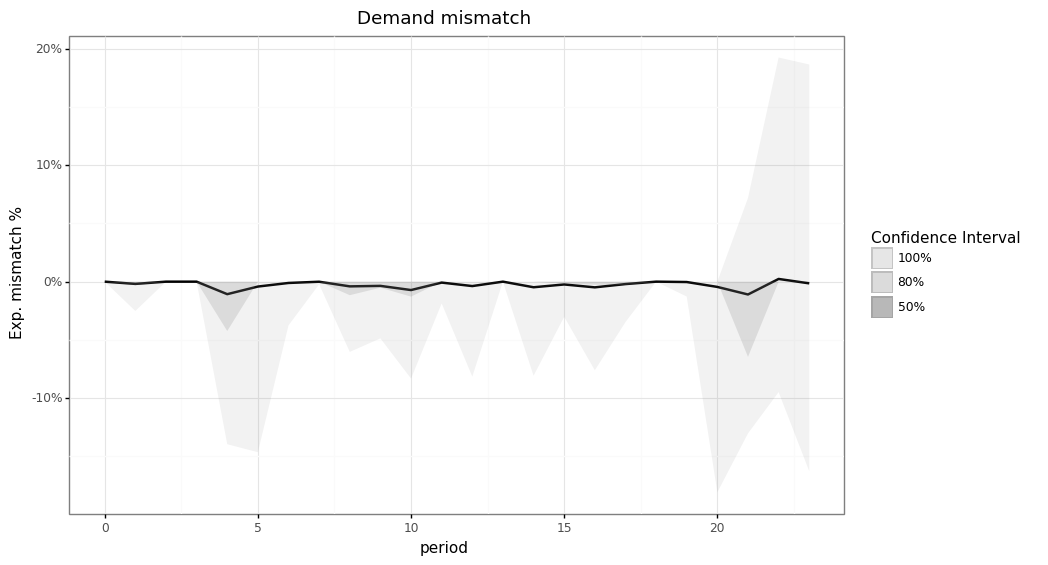

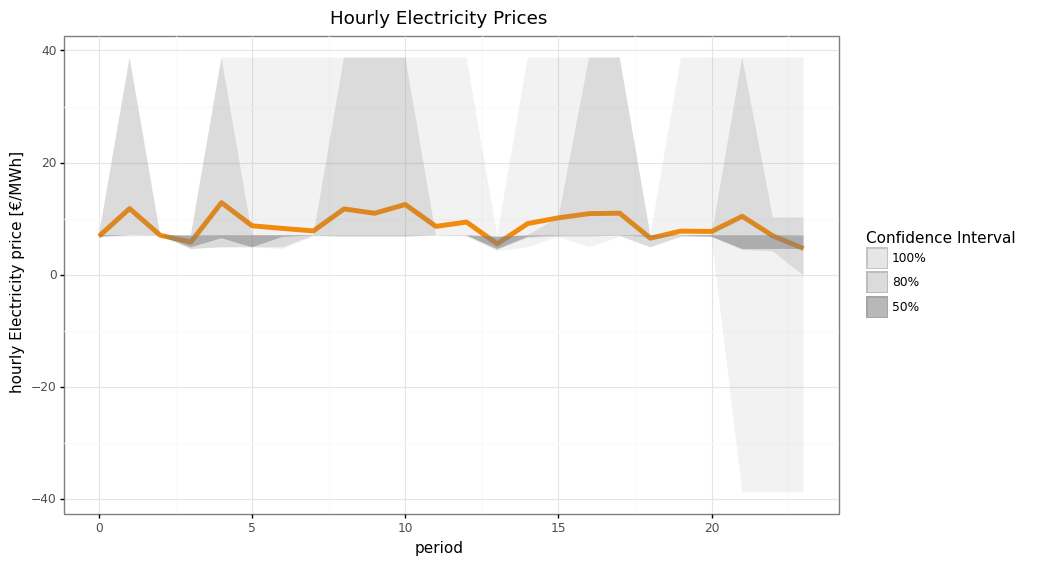

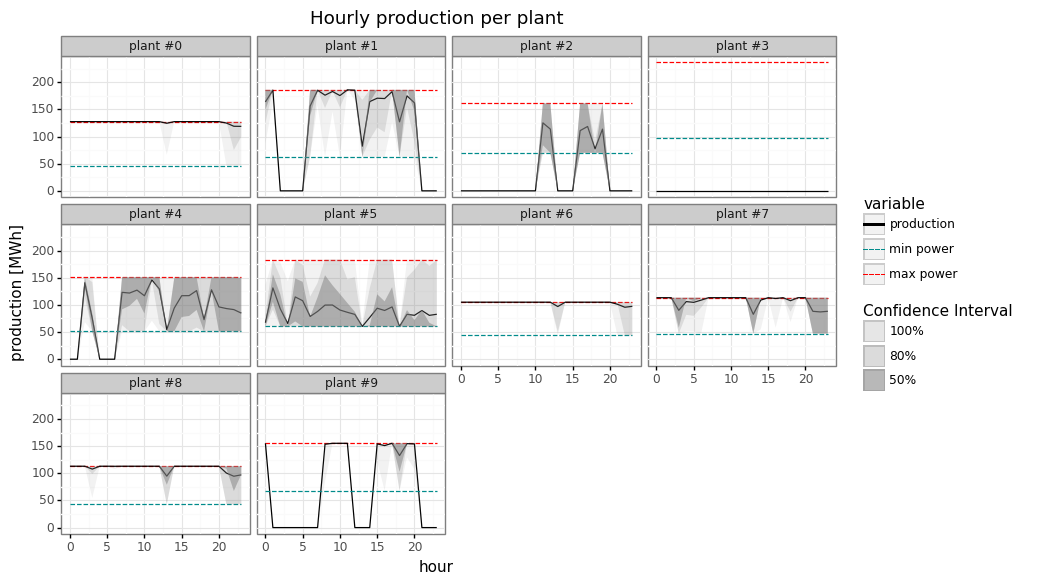

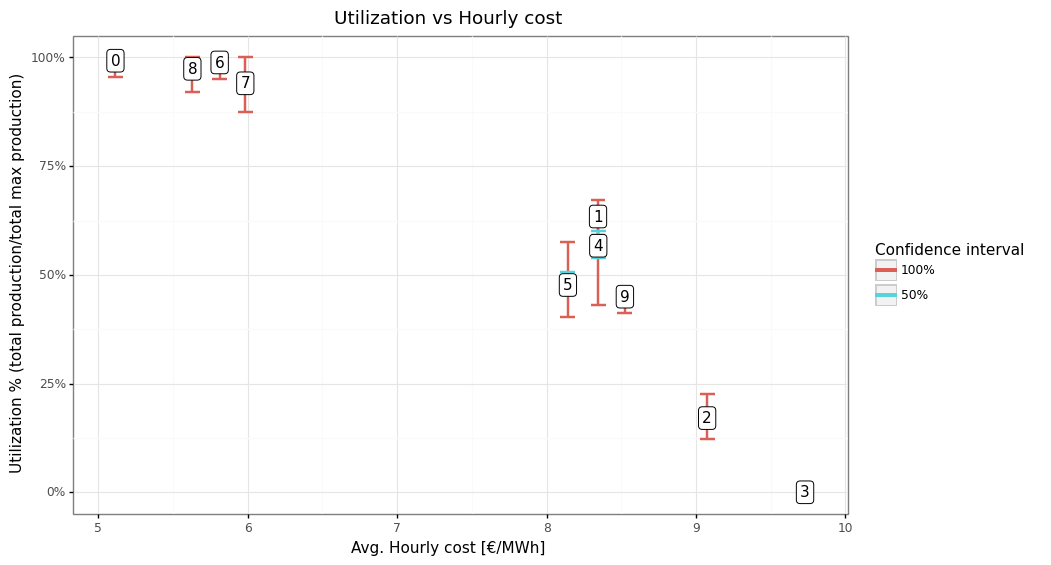

In [10]:
plots = [charts.total_production(data, solution),
 charts.enp_vs_eie(data, scenarios, solution),
 charts.electricity_prices(data, scenarios, solution, stoch_ucp),
 charts.production_by_plant(data, solution),
 charts.plant_utilization(data, solution)]

for p in plots:
    print(p)

## Solution Evaluation: Stochastic vs Deterministic solution

Given a vector of schedules for the power plants $\mathbf{s}'$, what would be the expected production cost across scenarios $\xi \in \Xi$?

The expected production cost, call it $\nu(\mathbf{s}')$ can be computed by solving the stochastic problem $\UCPS_\Xi$, fixing the commitments $\mathbf{\var{s}}$ to $\mathbf{s}'$:
$$ 
\begin{align} 
\nu(\mathbf{s}') = \{\min ~& \mathbf{c}^\top \var{\mathbf{s}} + \sum_{\xi \in \Xi} \pi_\xi \left (\mathbf{l}^\top \var{\mathbf{p}_\xi} + c_{ENP} \var{\textbf{ENP}_\xi} +  c_{EIE} \var{\mathbf{EIE}_\xi} \right)\\
 \textrm{s.t.} ~&  \var{\mathbf{s}} = \mathbf{s}' \\
& [\var{\mathbf{s}}, \var{\mathbf{p}_\xi}, \var{\textbf{ENP}_\xi}, \var{\textbf{EIE}_\xi}] = \var{\mathbf{x}_\xi} \in \mathcal{X}_{\Xi} ~~\forall \xi \in \Xi \}
\end{align}$$

Consider then two schedules:

* the deterministic schedule $\mathbf{s}_{\mathrm{DET}}$, computed by assuming the electricity demand is equal to the expected value/pointwise forecast.<br>This schedule is computed by either solving the "base" UCP problem in the other notebook, called hereafter $\UCPD$, or, equivalently, by providing the Stochastic UCP a single scenario with the expected demand.

* the stochastic(-aware) schedule $\mathbf{s}_{\mathrm{STOCH}}$, computed by the stochastic UCP model $\UCPS$, for which $\nu(\mathbf{s}_{\mathrm{STOCH}})= \mathrm{opt}~\UCPS$

Since the deterministic schedule is not aware of alternative scenarios, its expected cost is going to be worse than the stochastic one
$$ \nu(\mathbf{s}_{\mathrm{STOCH}}) \le \nu(\mathbf{s}_\mathrm{DET})$$

However, the optimal value of the deterministic model $\UCPD$ is likely to be better than its expected cost, and, potentially, the expected cost of the stochastic solution, as it ignores the scenarios other than the expected demand, thus providing an unrealistic solution:
$$ \mathrm{opt}~\UCPD \le \min (\nu(\mathbf{s}_\mathrm{DET}), \nu(\mathbf{s}_\mathrm{STOCH}))$$

In other words, the deterministic model is going to report a better solution by underestimating the actual cost of the schedule over the scenarios in $\Xi$

In [11]:
stoch_eval = evaluate_solution(data, scenarios, solution, stoch_ucp)

In [12]:
def get_deterministic_evaluation(data):
    ucp = modeller.create_model(data)
    ucp.solve(PULP_CBC_CMD(msg=0))
    solution = extract_solution(ucp)
    cost = solution["total_production_cost"]
    evaluation = evaluate_solution(data,scenarios, solution, stoch_ucp)
    
    return cost, evaluation

det_cost, det_eval = get_deterministic_evaluation(data)

In the following chart we report the evaluation of stochastic and deterministic schedules, obtained solving $\UCPS$ and $\UCPD$ respectively.

In the chart the lines correspond to:

* black: cost reported by the Deterministic model $\UCPD$
* <font color="red">red</font>: expected cost for the deterministic schedule $\nu(\mathbf{s}_\textrm{DET})$
* <font color="cyan">cyan</font>: expected cost for the stochastic schedule $\nu(\mathbf{s}_\textrm{STOCH})$

And the densities represent the distribution of production costs over the scenarios $\xi\in \Xi$, i.e. the terms in the objective function of $\UCPS$: 
$$\mathbf{c}^\top \var{\mathbf{s}} + \left (\mathbf{l}^\top \var{\mathbf{p}_\xi} + c_{ENP} \var{\textbf{ENP}_\xi} +  c_{EIE} \var{\mathbf{EIE}_\xi} \right)$$.

The stochastic solution achieves lower expected cost than the deterministic one by being more cost-efficient for several scenarios, specifically avoiding the "long-tail" of expensive scenarios to the right.


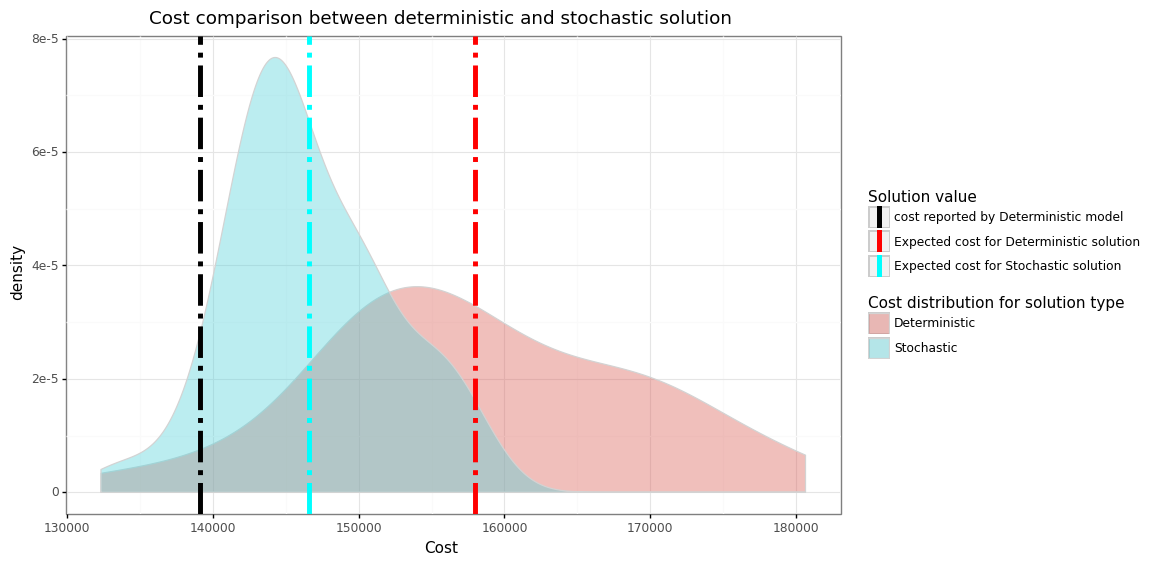

<ggplot: (8759880048788)>

In [13]:
charts.compare_deterministic_stochastic(det_cost, det_eval, stoch_eval)